<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 3. Continuity 
## Heat transport with  `scalarTransportFoam`
---
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

**In this notebook, we will learn to**

- use `scalarTransportFoam` to prepare a simple model for solving the continuity
equation for transporting heat. 

**Prerequisites:** (text)

**Result:** You should get a figure similar to
<img src="images/HeatTransport.jpg" style=width:10cm>

<a href="#top">**Table of contents**</a>

1. [Solver and equations](#one)
2. [Implementation](#two)
3. [Running](#three)
4. [Post-processing](#four)
5. [Technical aspects](#five)

<div id="one"></div>

----
## 1. Solver and equations

`scalarTransportFoam` is a 

- transient
- incompressible

solver for the transport equation.

We thus need the continuity equation and the Fourier law:
$$
\begin{array}{rcl}
\rho c_p \frac{\partial T}{\partial t} 
+ \rho c_p \vec{u} \cdot \nabla T  
+ \nabla \cdot \vec{F} &=& H \\
\vec{F} &=& - K_h \nabla T
\end{array}
$$
with
$\rho$ [kg/m$^3$] density,
$c_p$ [J/kg/K] specific heat,
$T$ [K] temperature,
$\vec{u}$ [m/s] velocity,
$t$ [s] time,
$\nabla$ [1/m] nabla operator,
$K_h$ [W/m/K] thermal conductivity, 
$F$ [J/m$^2$/s] heat flux, and
$H$ [W/m$^3$] heat sources.

Inserting yields:
$$
\frac{\partial T}{\partial t} 
+ \vec{u} \cdot \nabla T  
- \nabla \cdot \kappa_h \nabla T = {{H}\over{\rho c_p}}
$$
with $\kappa$ [m$^2$/s] thermal diffusivity.

This equation is solved by `scalarTransportFoam`...

<div id="two"></div>

----
## 2. Implementation

We consider flow along a channel 10 m long, from left to right:
<img src="images/1D_transport.jpg" style=width:15cm>
Black numbers mark sizes, red numbers are vertex numbers.

For the 1D transport of heat, we have an inflow face (0 4 7 3) and an outflow face (1 2 6 2).
The numbering of faces mark the **unit normal vector** in a right-hand side sense, thus for both
faces, the unit vector points outwards.

The other faces are not relevant, as we consider a 2D problem, thus they will be defined empty.

We have to set up the **mesh**, the **initial conditions**, a **temperature anomaly**, then **run** the program.

### Directory structure and files

~~~
HeatTransport_scalarTransportFoam
|-- 0
  |-- U
  |-- T
|- constant
  |-- transportProperties
|- system
  |-- blockMesh
  |-- controlDict
  |-- fvSchemes
  |-- fvSolution
  |-- setFieldsDict
~~~

- `system/blockMeshDict`
Eight vertices are defined, use the figure above. Only two faces, inflow and outflow side, are relevant, and defined as patches. Choose direction of points such that the normal vectors are pointing outside! Create one block, with 1000 elements in $x$ direction.

<details><summary><b>> Show code</b></summary>

~~~
convertToMeters 1;

vertices
(
    ( 0 -1 -1)
    (10 -1 -1)
    (10  1 -1)
    ( 0  1 -1)
    ( 0 -1  1)
    (10 -1  1)
    (10  1  1)
    ( 0  1  1)
);

blocks
(
    hex (0 1 2 3 4 5 6 7) (1000 1 1) simpleGrading (1 1 1)
);

edges
(
);

boundary
(
    sides
    {
        type patch;
        faces
        (
            (1 2 6 5)
            (0 4 7 3)
        );
    }
    empty
    {
        type empty;
        faces
        (
            (0 1 5 4)
            (5 6 7 4)
            (3 7 6 2)
            (0 3 2 1)
        );
    }
);

mergePatchPairs
(
);
~~~

</details>

- `0/U.orig`
Set entire velocity field to zero. We use `U.orig` as file here, because we modify the initial 
conditions later with `setFields`. 

<details><summary><b>> Show code</b></summary>

~~~
dimensions      [0 1 -1 0 0 0 0];

internalField   uniform (0 0 0);

boundaryField
{
    sides
    {
        type            zeroGradient;
    }
    empty
    {
        type            empty;
    }
}
~~~

</details>

- `0/T.orig`
Set entire temperature field to 10 degrees. We use `T.orig` as file here, because we modify the initial 
conditions later with `setFields`. 

<details><summary><b>> Show code</b></summary>

~~~
dimensions      [0 0 0 1 0 0 0];

internalField   uniform 10;

boundaryField
{
    sides
    {
        type            zeroGradient;
    }

    empty
    {
        type            empty;
    }
}
~~~

</details>

- `constant/transportProperties`
We set the thermal diffusivity, following the table below.

<details><summary><b>> Show code</b></summary>

~~~
  DT              DT [0 2 -1 0 0 0 0] 1e-6; // run1a
//DT              DT [0 2 -1 0 0 0 0] 1e-4; // run1b
//DT              DT [0 2 -1 0 0 0 0] 1e-2; // run1c
//DT              DT [0 2 -1 0 0 0 0] 1e-6; // run2a
//DT              DT [0 2 -1 0 0 0 0] 1e-6; // run3a
//DT              DT [0 2 -1 0 0 0 0] 1e-2; // run3c
~~~

</details>

- `system/controlDict`
We set a run time of 8s. We assume a maximum velocity of $u=1$m/s, have discretised with $\Delta x=0.01$m in
$x$ direction. For a **Courant number** below 1, we use
$$
C = {{u \Delta t}\over{\Delta x}} < 1
$$
thus $\Delta t < 0.01$s should be sufficient. 
Saving interval `writeInterval` is set to 1s.

<details><summary><b>> Show code</b></summary>

~~~
application     scalarTransportFoam;
startFrom       startTime;
startTime       0;
stopAt          endTime;
endTime         8.0;
deltaT          0.01;
writeControl    runTime;
writeInterval   1;
purgeWrite      0;
writeFormat     ascii;
writePrecision  6;
writeCompression off;
timeFormat      general;
timePrecision   6;
runTimeModifiable true;
~~~

</details>

- `system/fvSchemes`

<details><summary><b>> Show code</b></summary>

~~~
ddtSchemes
{
    default         Euler;
}

gradSchemes
{
    default         Gauss linear;
}

divSchemes
{
    default         none;
    div(phi,T)      Gauss linearUpwind grad(T);
}

laplacianSchemes
{
    default         none;
    laplacian(DT,T) Gauss linear corrected;
}

interpolationSchemes
{
    default         linear;
}

snGradSchemes
{
    default         corrected;
}
~~~

</details>

- `system/fvSolution`

<details><summary><b>> Show code</b></summary>

~~~
solvers
{
    T
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1e-06;
        relTol          0;
    }
}

SIMPLE
{
    nNonOrthogonalCorrectors 0;
}
~~~

</details>

- `system/setFieldsDict`
is new. Here we assign field conditions:

<details><summary><b>> Show code</b></summary>

~~~
defaultFieldValues ( volVectorFieldValue U (0.5 0 0) volScalarFieldValue T 10. );

regions         ( boxToCell { box (4.5 -1 -1) (5.5 1 1) ; fieldValues ( volScalarFieldValue T 20. ) ; } );
~~~

</details>

The velocity in the above case is set to $0.5$m/s in $x$-direction, temperatures to 10$^{\circ}$C,
except in a box region between 4.5 and 5.5m, here they are elevated to 20$^{\circ}$C.
Note that this dictionary needs to be processed before running the code with `setFields`.

We set up a sensitivity study. $U$ [m/s] is the velocity in $x$ direction, $DT$ [m$^2$/s] the
thermal diffusivity.

| U/DT    | $10^{-6}$ | $10^{-4}$ | $10^{-2}$ |
|---------|-----------|-----------|-----------|
|0.0      | run1a     | run1b     | run1c     |
|0.2      | run2a     | -         | -         |
|0.5      | run3a     | -         | run3c     |

<div id="three"></div>

----
## 3. Running

Running a particular example is done with the following set of commands:
~~~
$ foamCleanTutorials
$ blockMesh
$ setFields
$ scalarTransportFoam
~~~

If the run was successful, create a dummy file `show.foam` in the directory and
open the run in `paraview`. In the case below, several runs have been loaded into
`paraview` and shifted for visibility.

<img src="images/HeatTransport.jpg" style=width:25cm>

<div id="four"></div>

----
## 4. Post-processing: Profiles

Use dictionary `system/sampleDict` to extract data after main run:

<details><summary><b>> Show code</b></summary>
    
~~~
type sets;

setFormat raw;

interpolationScheme cell;
//interpolationScheme cellPoint;
//interpolationScheme cellPointFace;

// Fields to sample.
fields
(
    T
);

sets
(
    transport1d_run1a
    {
        type          uniform;
        nPoints       100;

        axis            xyz;
        start           ( 0  0.0 0.0);
        end             (10  0.0 0.0);
    }

);
~~~
</details>

Run:

~~~
$ postProcess -func sampleDict -latestTime
~~~

The `postProcess` code creates in this case sampled data for temperature $T$ in a directory
`postProcessing/sampleDict/8/transport1D_run1a_T.xy` for each run.

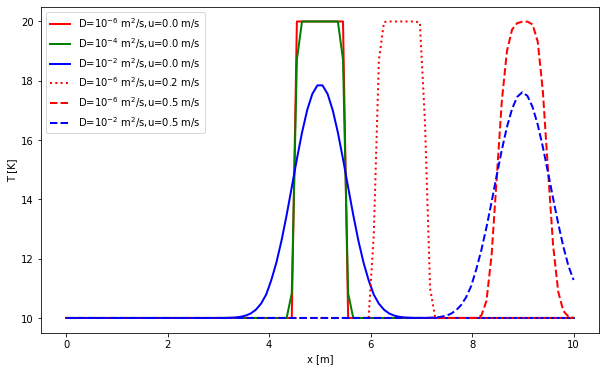

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# calculate analytical data
def T(x,T0=400,T1=500):
    Hsternrhocp = 1e-5
    D           = 1e-6
    L           = 10
    c1 = (T1-T0)/L + Hsternrhocp/2/D*L
    c2 = T0
    T = -Hsternrhocp/2/D*x**2 + c1*x + c2
    return T
    
# load laplacianFoam postprocessed data
data1a = np.loadtxt('data/transport1D_run1a_T.xy')
data1b = np.loadtxt('data/transport1D_run1b_T.xy')
data1c = np.loadtxt('data/transport1D_run1c_T.xy')
data2a = np.loadtxt('data/transport1D_run2a_T.xy')
data3a = np.loadtxt('data/transport1D_run3a_T.xy')
data3c = np.loadtxt('data/transport1D_run3c_T.xy')

plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('T [K]')
#plt.plot(x,Tanalytical,linewidth=10,color='gray',label='analytical')
plt.plot(data1a[:,0],data1a[:,3],linewidth=2,color='red',label='D=10$^{-6}$ m$^2$/s,u=0.0 m/s')
plt.plot(data1b[:,0],data1b[:,3],linewidth=2,color='green',label='D=10$^{-4}$ m$^2$/s,u=0.0 m/s')
plt.plot(data1c[:,0],data1c[:,3],linewidth=2,color='blue',label='D=10$^{-2}$ m$^2$/s,u=0.0 m/s')
plt.plot(data2a[:,0],data2a[:,3],linewidth=2,linestyle=':',color='red',label='D=10$^{-6}$ m$^2$/s,u=0.2 m/s')
plt.plot(data3a[:,0],data3a[:,3],linewidth=2,linestyle='--',color='red',label='D=10$^{-6}$ m$^2$/s,u=0.5 m/s')
plt.plot(data3c[:,0],data3c[:,3],linewidth=2,linestyle='--',color='blue',label='D=10$^{-2}$ m$^2$/s,u=0.5 m/s')
plt.legend()

... done